In [1]:
import pandas as pd
import numpy as np

In [2]:
raw_data = pd.read_csv('Case Study Data.csv')

In [3]:
# make sure data is correctly read in
raw_data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56.0,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57.0,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37.0,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,NaN,-36.4,4.857,5191.0,no
3,40.0,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56.0,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,NaN,-36.4,4.857,5191.0,no


In [4]:
# make sure all the changes we will make in the following steps do not impact the original dataset
df = raw_data.copy()

# check data types and null values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             37444 non-null  float64
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  36040 non-null  float64
 17  cons.conf.idx   41188 non-null 

In [5]:
# more straightforward to see which variables has how many lines of null entries
df.isnull().sum()

age               3744
job                  0
marital              0
education            0
default              0
housing              0
loan                 0
contact              0
month                0
day_of_week          0
duration             0
campaign             0
pdays                0
previous             0
poutcome             0
emp.var.rate         0
cons.price.idx    5148
cons.conf.idx        0
euribor3m            0
nr.employed          0
y                    0
dtype: int64

<h1> Deal with NaN entry </h1>
<li>Observe null value detected in columns: 1. 'age' 2. cons.price.idx</li>

<li>Since 'cons.price.idx' is not client specific, I try to find similar rows with non-null entries in this field, and get the value there to replace the null value here.</li>
<p style="margin-left:40px;margin-right:100px">
    Specifically, what I am thinking is: since both cons.price.idx and cons.conf.idx is a monthly indicator, and we have a both columns 'month' and 'cons.conf.idx' non-null <br /> => If two rows with the same 'month' and 'cons.conf.idx' entries, then these two rows should also have same 'cons.price.idx' entry. <br />
    => Using this logic, we can impute null entries for 'cons.price.idx'
<li>Age is client specific; it is not directly related to any other variables, so we can not get that exact number from manipulating the dataset. <p style="margin-left:40px;margin-right:100px">
    => We might try to predict 'age' using other columns, but the accuracy cannot be guaranteed (might add more noise to the data). Additionally, since we have such a large dataset, and the null entries are just 9% (3744/41188) of the total dataset, it would not hurt much if we just delete them. <br /> => So we decide to proceed by deleting those rows. </li>

In [6]:
# separate non-null data so that we can get unique entries easier
df_not_null = df[df['cons.price.idx'].notnull()]
df_not_null['month_cpi_cci'] = df_not_null[['month', 'cons.price.idx', 'cons.conf.idx']].apply(tuple, axis = 1)
unique = df_not_null['month_cpi_cci'].unique()


# create a dictionary, key = (month, cons.conf.idx), value = cons.price.idx
unique_dict = dict(((x,z), y) for x, y, z in unique)
unique_dict


# create tuple pairs in the whole dataframe, so that we can use this as the mapping key in the following step
df['month_cci'] = df[['month', 'cons.conf.idx']].apply(tuple, axis = 1)


# the function replace null entries with valid ones
def fix_cpi(row):
    if row['month_cci'] in unique_dict.keys() and pd.isnull(row['cons.price.idx']):
        row['cons.price.idx'] = unique_dict.get(row['month_cci'])        
    return row

<ipython-input-6-ff5547625c81>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_not_null['month_cpi_cci'] = df_not_null[['month', 'cons.price.idx', 'cons.conf.idx']].apply(tuple, axis = 1)


In [7]:
df = df.apply(lambda x: fix_cpi(x), axis = 1)


# check if null values are populated
df.isnull().sum()

age               3744
job                  0
marital              0
education            0
default              0
housing              0
loan                 0
contact              0
month                0
day_of_week          0
duration             0
campaign             0
pdays                0
previous             0
poutcome             0
emp.var.rate         0
cons.price.idx       0
cons.conf.idx        0
euribor3m            0
nr.employed          0
y                    0
month_cci            0
dtype: int64

In [8]:
# deletes the rows with null entry in age
# again, the data we throw away does not have too much weight on the whole dataset, so it is a valid move
df = df[df['age'].notnull()]


# from this point on, we no longer need the column 'month_cci', so we drop it
df.drop(columns = ['month_cci'], inplace = True)


# check if null values are removed; check if last column is removed
df.isnull().sum()

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64

<h1>Deal with Deplicates</h1>
<li>We see the existence of duplicates. But the problem here is we do not have a unique key like client_id in the dataset to differentiate each client. So we are not sure if these duplicate are double entries for the same client, or it is just two client share the exact same information</li>
<li>My consideration here is that, it is possible for clients to share same age, job, etc. But it is very unlikely for them to share 11 exact same features, among which we even have 'duration' measured in seconds. </li>
<p style="margin-left:40px;margin-right:100px">
    Based on this, my judgement is that <br />
    => These are duplicates, and need to be deleted


In [9]:
df.duplicated().unique()

array([False,  True])

In [10]:
df[df.duplicated(keep=False)]['duration']

1265     124
1266     124
12260     88
12261     88
14155    331
14234    331
16819     43
16956     43
18464    128
18465    128
20072     33
20216     33
20531    127
20534    127
25183    123
25217    123
28476    114
28477    114
32505    348
32516    348
36950    252
36951    252
38255    120
38281    120
Name: duration, dtype: int64

In [11]:
# 24/2 = 12 duplicates to be deleted
len(df[df.duplicated(keep=False)]['duration'])

24

In [12]:
# delete duplicates
df.drop_duplicates(inplace = True)


# check again that the previous step is succussful
# 37444 - 12 = 37432
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37432 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             37432 non-null  float64
 1   job             37432 non-null  object 
 2   marital         37432 non-null  object 
 3   education       37432 non-null  object 
 4   default         37432 non-null  object 
 5   housing         37432 non-null  object 
 6   loan            37432 non-null  object 
 7   contact         37432 non-null  object 
 8   month           37432 non-null  object 
 9   day_of_week     37432 non-null  object 
 10  duration        37432 non-null  int64  
 11  campaign        37432 non-null  int64  
 12  pdays           37432 non-null  int64  
 13  previous        37432 non-null  int64  
 14  poutcome        37432 non-null  object 
 15  emp.var.rate    37432 non-null  float64
 16  cons.price.idx  37432 non-null  float64
 17  cons.conf.idx   37432 non-null 

<h1>Detail Look at Numeric Values</h1>

### 'pdays'

   <br/> 1. large standard deviation <br/> 2. mean is close to 999 (which has no numeric meaning, but indicate 'not previously contacted'  <br/> 3. Not too many distinct values <br/> 4. Except 999, all other days are within a month <br/>  => Consider transform this variable using range (within 10 days; 10 to 20 days; 20 to 30 days; over 30) <br/> => Take it as categorical when modeling <br/> 



In [13]:
df.describe()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,37432.000000,37432.000000,37432.000000,37432.000000,37432.000000,37432.000000,37432.000000,37432.000000,37432.000000,37432.000000
mean,39.999653,258.295977,2.567135,962.446303,0.172820,0.085384,93.576571,-40.496134,3.625405,5167.168949
std,10.414278,258.193449,2.767477,186.978916,0.495688,1.569035,0.578310,4.624262,1.732808,72.179805
min,17.000000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.000000,103.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.000000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.000000,320.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.000000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


In [14]:
df['pdays'].unique()

array([999,   6,   4,   5,   1,   0,   3,  10,   7,   8,   9,  11,   2,
        12,  13,  14,  15,  16,  21,  17,  18,  22,  25,  26,  19,  27,
        20])

In [15]:
#df.loc[ df[“column_name”] == “some_value”, “column_name”] = “value”

df.loc[df['pdays'] < 10, 'pdays'] = 0
df.loc[(df['pdays'] < 20) & (df['pdays'] >= 10), 'pdays'] = 1
df.loc[(df['pdays'] < 30) & (df['pdays'] >= 20), 'pdays'] = 2
df.loc[df['pdays'] > 30, 'pdays'] = 3

In [16]:
df['pdays'].unique()

array([3, 0, 1, 2])

### 'age' & 'campaign' & 'previous' 
<li> May or may not have some outliers  <br/> => use box plot to confirm </li> <li> We found that outliers do exist. But since the range of these variables are not large, and the number of rows are not too many, we decide to retain the data. Because if we delete them all, we might end up losing some impact. So we lieave it here, and let the machine learn</li>


/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='age'>

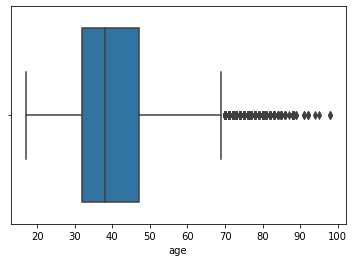

In [17]:
import seaborn as sns

sns.boxplot(df['age'])

In [18]:
        '''
        382 rows is only 1% of the data; 
        The tail is not too far from the body, so doesn't matter too much
        => will not interfere at this point
        '''

print(len(df[df['age']>70]),len(df[df['age']>90]))

382 9


/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='campaign'>

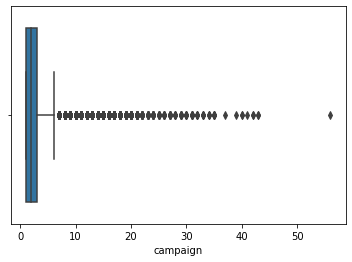

In [19]:
sns.boxplot(df['campaign'])

In [20]:
# delete the most far away outlier

print(len(df[df['campaign']>7]),len(df[df['campaign']>50]))

df[df['campaign'] > 50]

1622 1


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
4107,32.0,admin.,married,university.degree,unknown,unknown,unknown,telephone,may,mon,...,56,3,0,nonexistent,1.1,93.994,-36.4,4.858,5191.0,no


In [21]:
df.drop(4107, inplace = True)

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='previous'>

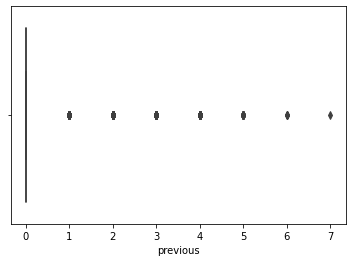

In [22]:
sns.boxplot(df['previous'])

In [23]:
# not going to delete since the range of this variable is small enough
print(len(df[df['previous']>1]))

965


### 'duration' 
<li>Not going to have this available at the point of making prediction </li>
<li> => remove

In [24]:
df.drop(['duration'], axis = 1, inplace = True)

#### Other variables such as 'cons.price.idx' are not sprcific to client; ignore

<h1>Relationships Among Variables</h1>

<li>'pdays' and 'previous' <br/> => I think these two are measuring very different things according to definition. So I will not do any adjustment</li>

<li>'cons.price.idx' and 'emp.var.rate'</li>
<li>'cons.price.idx' and 'euribor3m'</li>
<li>'cons.price.idx' and 'nr.employed'</li>
<li>'euribor3m' and 'emp.var.rate'</li>
<li>'nr.employed' and 'emp.var.rate'</li>
<li>'nr.employed' and 'euribor3m' <br/> => Correlation exists for these variables, but relationship is not definite
    <br/> => It's a possible option for us to retain one variable out of the two similar ones, or combine some of them with arithmatic means or other methods. 
    <br/> => But to avoid my action might be too arbitrary and end up adding noise to the data, I will leave all these macro factors here, let the model tell their influence
</li>


<AxesSubplot:>

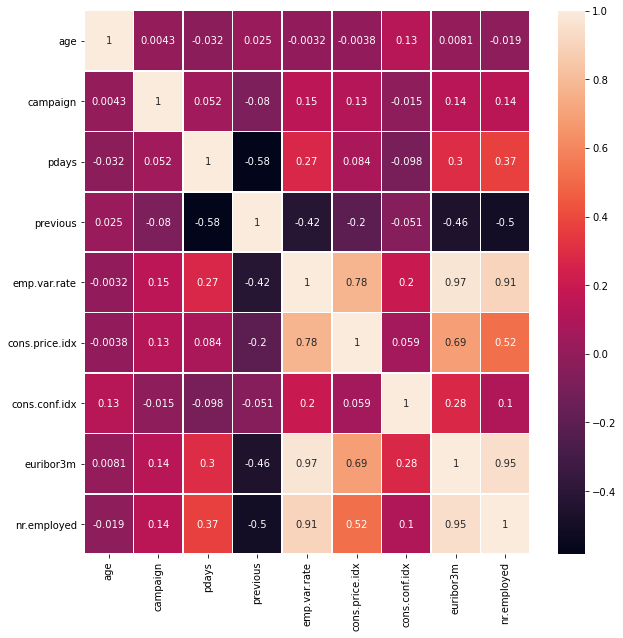

In [25]:
import matplotlib.pyplot as plt

correlation = df.corr()

fig, ax = plt.subplots(figsize=(10,10))         
sns.heatmap(correlation, xticklabels = correlation.columns, yticklabels = correlation.columns, 
            annot = True, linewidth = 0.5, ax = ax)


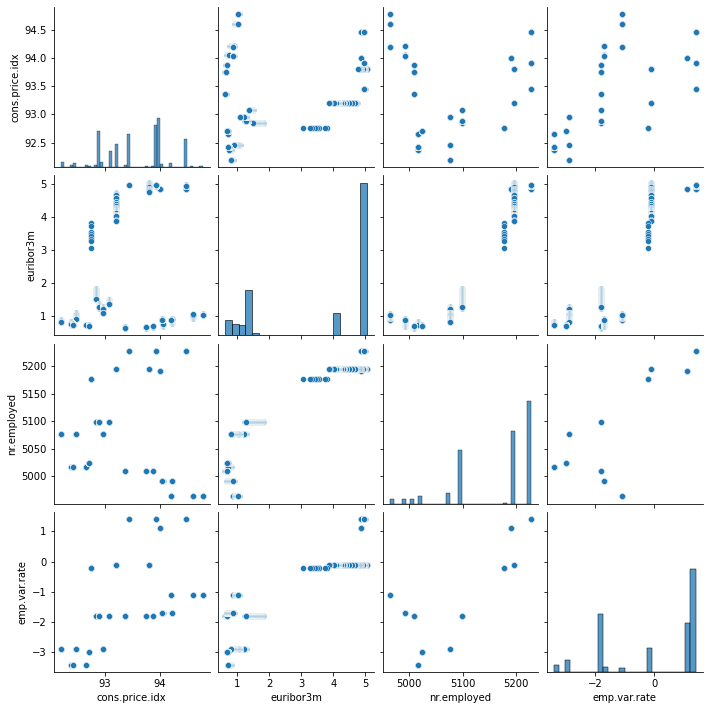

In [26]:
sns.pairplot(df[['cons.price.idx', 'euribor3m', 'nr.employed', 'emp.var.rate']])

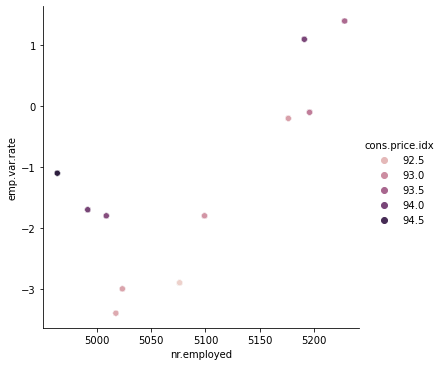

In [27]:
sns.relplot(x = 'nr.employed', y = 'emp.var.rate', hue = 'cons.price.idx', data = df)

<h1>Dive into Outcome Variable y</h1>

#### Unbalanced Labels 
=> We might not just use prediction accuracy as an evaluation metric. Because the accuracy will be high even if we do nothing and simply set every 'y' = 'no' <br/> => Will need to play around with evaluation metrics</li>


In [28]:
print('# rows when client subscribe to the product = ' + str(len(df[df['y'] == 'yes']))) 
print('Proportion of those rows in the whole dataset = ' + str(len(df[df['y'] == 'yes'])/len(df)))
print("# of 'no' to # of 'yes' = " + str(len(df[df['y'] == 'no'])/len(df[df['y'] == 'yes'])))

# rows when client subscribe to the product = 4197
Proportion of those rows in the whole dataset = 0.11212631241484332
# of 'no' to # of 'yes' = 7.918513223731237


[Text(0.5, 1.0, 'count of y variable')]

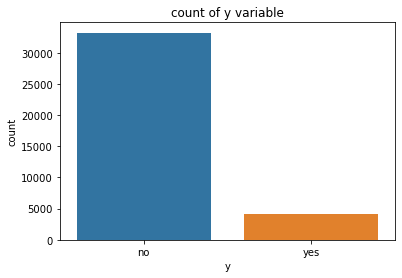

In [29]:
sns.countplot(x = 'y', data = df).set(title = 'count of y variable')

### Explore categorical variables' relationship with the outcome
#### Job

[Text(0.5, 1.0, 'Job & y')]

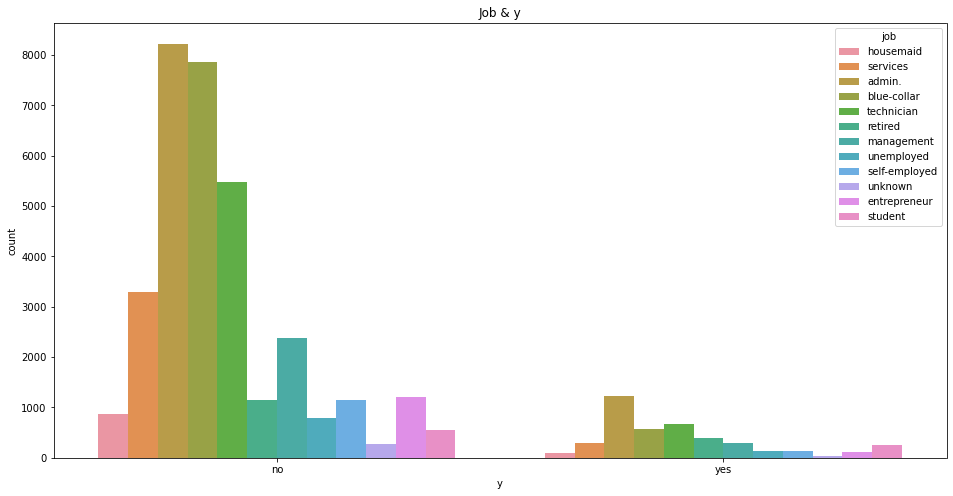

In [30]:
# some variation 
# => keep 
fig, ax = plt.subplots(figsize=(16,8))
sns.countplot(x = 'y', hue = 'job', data = df, linewidth = 0.5, ax = ax).set(title = 'Job & y')

#### Marital

[Text(0.5, 1.0, 'Marital & y')]

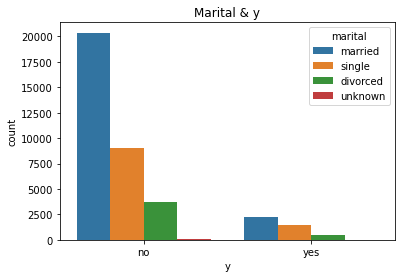

In [31]:
# Similar
# => Delete
sns.countplot(x = 'y', hue = 'marital', data = df).set(title = 'Marital & y')

#### Education

[Text(0.5, 1.0, 'Education & y')]

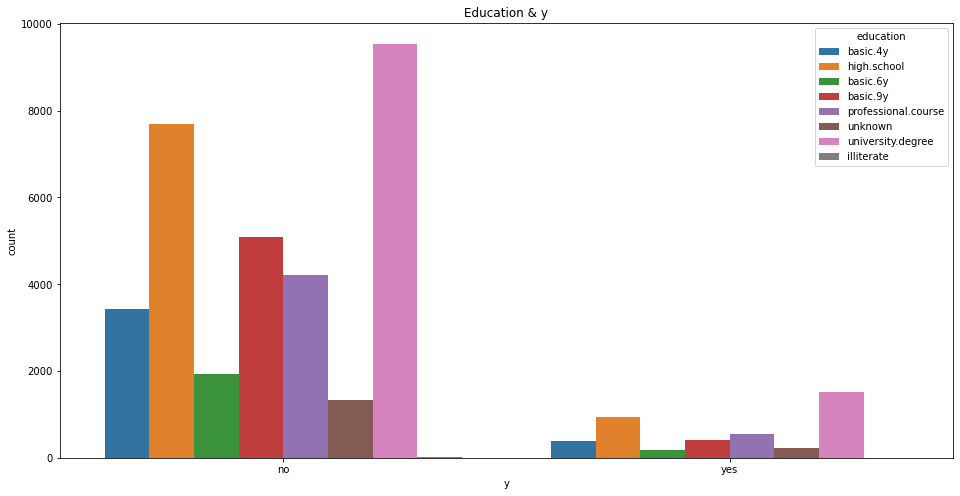

In [32]:
# some variation (especially basic.9y vs. professional.course)
# => keep  
fig, ax = plt.subplots(figsize=(16,8))
sns.countplot(x = 'y', hue = 'education', data = df, linewidth = 0.5, ax = ax).set(title = 'Education & y')

#### Housing

[Text(0.5, 1.0, 'Housing & y')]

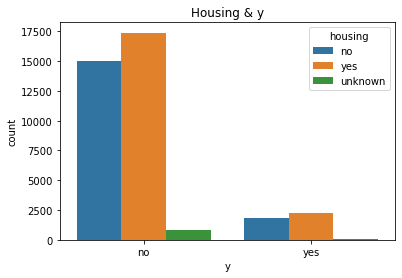

In [33]:
# Similar shape, but some variation
# => Might consider not using this variable in modeling
# => I choose to keep it here, and let the model figure out if it has influence (since it only adds one column)
sns.countplot(x = 'y', hue = 'housing', data = df).set(title = 'Housing & y')

#### Default

[Text(0.5, 1.0, 'Default status & y')]

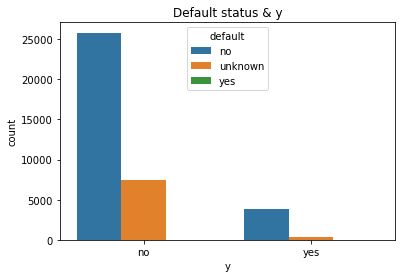

In [34]:
# Similar shape
# => delete
sns.countplot(x = 'y', hue = 'default', data = df).set(title = 'Default status & y')

#### Loan

[Text(0.5, 1.0, 'Loan & y')]

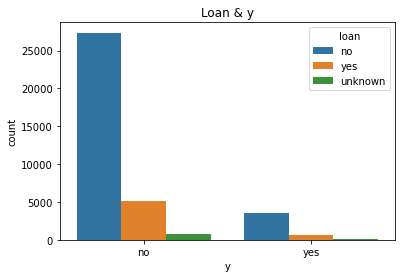

In [35]:
# Similar shape
# => delete
sns.countplot(x = 'y', hue = 'loan', data = df).set(title = 'Loan & y')

#### Contact

[Text(0.5, 1.0, 'Contact & y')]

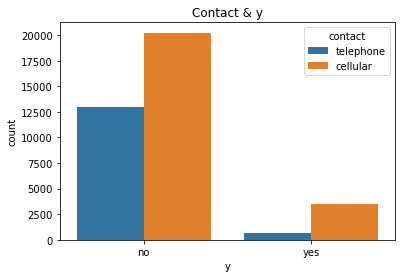

In [36]:
# Some variation
# => keep
sns.countplot(x = 'y', hue = 'contact', data = df).set(title = 'Contact & y')

#### Month

[Text(0.5, 1.0, 'Month & y')]

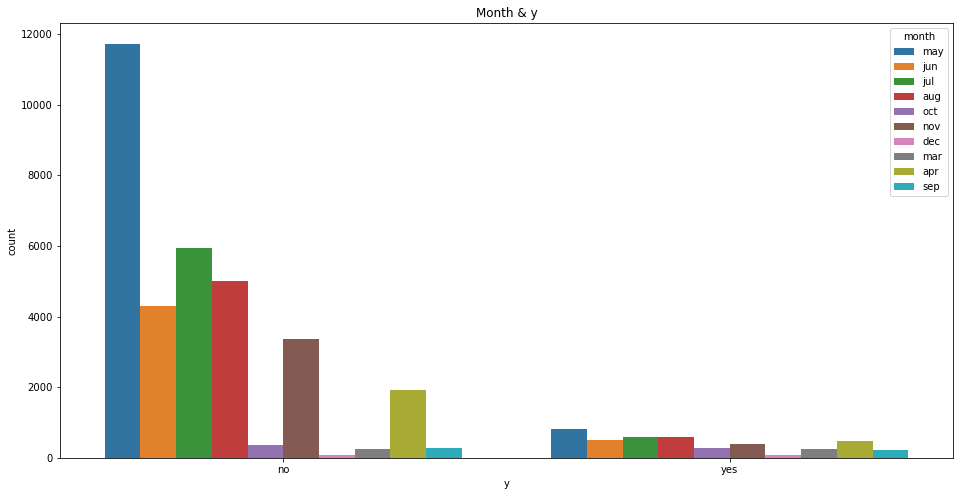

In [37]:
# Some variation
# => Keep
fig, ax = plt.subplots(figsize=(16,8))
sns.countplot(x = 'y', hue = 'month', data = df, linewidth = 0.5, ax = ax).set(title = 'Month & y')

#### day_of_week

[Text(0.5, 1.0, 'day_od_week & y')]

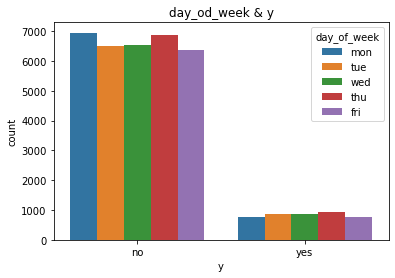

In [38]:
# some variation (mon vs tue)
# => keep  
sns.countplot(x = 'y', hue = 'day_of_week', data = df).set(title = 'day_od_week & y')

#### pdays

<ipython-input-39-0587c3e08383>:7: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


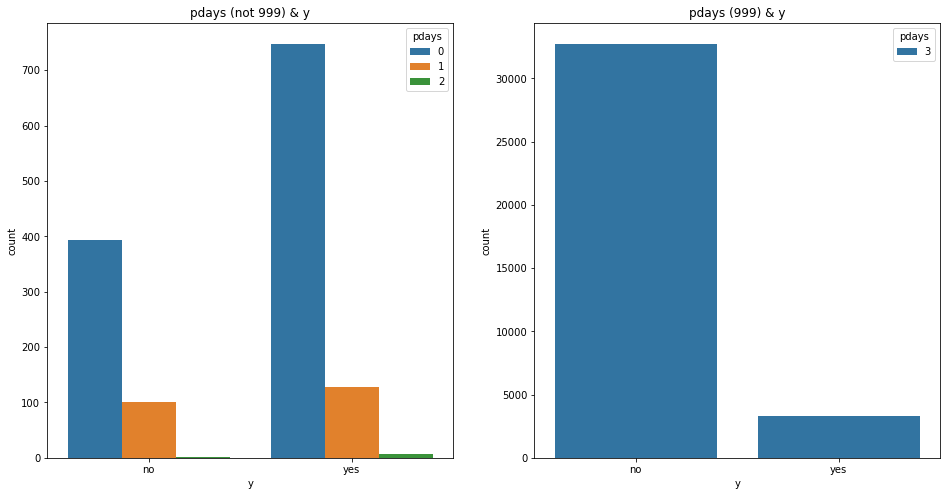

In [39]:
# different when pdays = 0 and pdays = 3
# => keep

fig, ax =plt.subplots(1,2, figsize=(16,8))
sns.countplot(x = 'y', hue = 'pdays', data = df[df['pdays'] != 3], ax = ax[0]).set(title = 'pdays (not 999) & y')
sns.countplot(x = 'y', hue = 'pdays', data = df[df['pdays'] == 3], ax = ax[1]).set(title = 'pdays (999) & y')
fig.show()

#### poutcome

[Text(0.5, 1.0, 'prev outcome & y')]

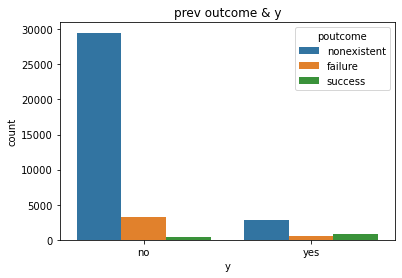

In [40]:
# very different
# => keep  
sns.countplot(x = 'y', hue = 'poutcome', data = df).set(title = 'prev outcome & y')

### Converting Categorical Variables
Based on the above analysis, we will keep
<li>job</li>
<li>education</li>
<li>housing</li>
<li>contact</li>
<li>month</li>
<li>day_of_week</li>
<li>pdays</li>
<li>poutcome</li>
<br/>
We will delete
<li>marital</li>
<li>default</li>
<li>loan</li>

In [41]:
job = pd.get_dummies(df['job'], drop_first = True)
education = pd.get_dummies(df['education'], drop_first = True)
housing = pd.get_dummies(df['housing'], drop_first = True)
contact = pd.get_dummies(df['contact'], drop_first = True)
month = pd.get_dummies(df['month'], drop_first = True)
day_of_week = pd.get_dummies(df['day_of_week'], drop_first = True)
pdays = pd.get_dummies(df['pdays'], drop_first = True)
poutcome = pd.get_dummies(df['poutcome'], drop_first = True)

# drop all columns replaced with dummies
# drop columns we decided to delete
df.drop(['job', 'education', 'housing', 'contact', 'month', 'day_of_week', 'pdays', 'poutcome',
        'marital', 'default', 'loan'], axis = 1, inplace = True)

# concat dummies back to the table
df = pd.concat([df, job, education, housing, contact, month, day_of_week, pdays, poutcome], axis = 1)

In [42]:
# transform 'no/yes' to '0/1'
# get 'y' out of the table, store it separately as label

df['y']=np.where(df['y']=='no',0,1)
label = pd.DataFrame(df['y'])

In [43]:
# drop unknowns
df.drop(['unknown','y'], axis = 1, inplace = True)
df = df.apply(pd.to_numeric)
df.columns

Index([                'age',            'campaign',            'previous',
              'emp.var.rate',      'cons.price.idx',       'cons.conf.idx',
                 'euribor3m',         'nr.employed',         'blue-collar',
              'entrepreneur',           'housemaid',          'management',
                   'retired',       'self-employed',            'services',
                   'student',          'technician',          'unemployed',
                  'basic.6y',            'basic.9y',         'high.school',
                'illiterate', 'professional.course',   'university.degree',
                       'yes',           'telephone',                 'aug',
                       'dec',                 'jul',                 'jun',
                       'mar',                 'may',                 'nov',
                       'oct',                 'sep',                 'mon',
                       'thu',                 'tue',                 'wed',
            

<h1>Start Modeling</h1>

### First Algorithm -- Logistic Regression

In [44]:
# Same seed allow us to get the same training and testing set when fitting different models
# More convenient to compare model performance
seed = 0

In [45]:
import sklearn.linear_model as sk_lm
import sklearn.model_selection as sk_ms

X_train, X_test, Y_train, Y_test = sk_ms.train_test_split(df, 
                                                          label, 
                                                          train_size=0.7, 
                                                          random_state=seed, 
                                                          shuffle=True)

lr = sk_lm.LogisticRegression(penalty='none')
lr.fit(X_train, np.ravel(Y_train))


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(penalty='none')

In [46]:
df_train = pd.concat([X_train, Y_train], axis = 1)
df_test = pd.concat([X_test, Y_test], axis = 1)

In [47]:
# lr_score represent the probability for a 1 (that a client will subscribe)
df_train['lr_score'] = [i[1] for i in lr.predict_proba(X_train)]
df_test['lr_score'] = [i[1] for i in lr.predict_proba(X_test)]

In [48]:
df_train.head(2)

,age,campaign,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,blue-collar,entrepreneur,...,thu,tue,wed,1,2,3,nonexistent,success,y,lr_score
30368,49.0,1,1,-1.8,93.075,-47.1,1.365,5099.1,0,0,...,1,0,0,0,0,1,0,0,1,0.226074
3644,29.0,2,0,1.1,93.994,-36.4,4.859,5191.0,0,1,...,0,0,0,0,0,1,1,0,0,0.046082


In [49]:
df_test.head(2)

,age,campaign,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,blue-collar,entrepreneur,...,thu,tue,wed,1,2,3,nonexistent,success,y,lr_score
17380,43.0,1,0,1.4,93.918,-42.7,4.962,5228.1,0,0,...,0,0,0,0,0,1,1,0,0,0.055392
2427,47.0,2,0,1.1,93.994,-36.4,4.856,5191.0,0,0,...,0,1,0,0,0,1,1,0,0,0.047000


<li>Take a look at model performance</li>

In [50]:
import sklearn.metrics as sk_m

# We set the threshold at 0.75 randomly, just to get an initial sense of model performance
sk_m.confusion_matrix(df_train['y'],
                      df_train.lr_score >= 0.75)

array([[23211,    13],
       [ 2908,    69]])

In [51]:
# confustion matrix metric analysis
def c_m_analysis(true,pred,threshold):
    tn, fp, fn, tp = sk_m.confusion_matrix(true,pred >= threshold).ravel()
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    fpr = fp/(fp+tn)
    f_score = 2*precision*recall/(precision+recall)
    accuracy = (tp+tn)/(tp+tn+fp+fn)
    print("Precision:\t\t\t%1.2f identified as 1s are 1s"%(precision))
    print("Recall/TPR:\t\t\t%1.2f proportions of actual 1s identified"%(recall))
    print("False Positive Rate:\t\t%1.2f proportion of 0s identified as 1s"%fpr)
    print("f-score:\t\t\t%1.2f tradeoff between precision and recall"%(f_score))
    print("Accuracy:\t\t\t%1.2f how well the model has classified"%(accuracy))

c_m_analysis(df_train['y'],df_train['lr_score'],0.75)

Precision:			0.84 identified as 1s are 1s
Recall/TPR:			0.02 proportions of actual 1s identified
False Positive Rate:		0.00 proportion of 0s identified as 1s
f-score:			0.05 tradeoff between precision and recall
Accuracy:			0.89 how well the model has classified


In [52]:
# Draw ROC curve to visualize the trade off between true positive rate and false positive rate
fpr, tpr, thresh = sk_m.roc_curve(df_train['y'], df_train['lr_score'])


# get optimal_threshold by maximizing (tpr - fpr)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresh[optimal_idx]
print(optimal_threshold)

0.13087604000481112


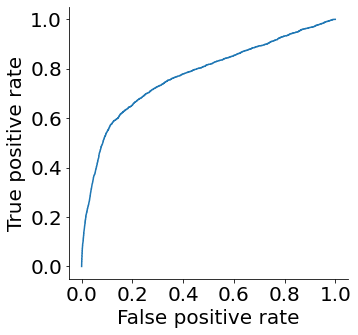

In [53]:
plt.figure(figsize=(5, 5))
plt.plot(fpr,tpr)
plt.xlabel('False positive rate', fontsize=20)
plt.ylabel('True positive rate', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
sns.despine()

In [54]:
c_m_analysis(df_train['y'],df_train['lr_score'],optimal_threshold)

Precision:			0.34 identified as 1s are 1s
Recall/TPR:			0.62 proportions of actual 1s identified
False Positive Rate:		0.15 proportion of 0s identified as 1s
f-score:			0.44 tradeoff between precision and recall
Accuracy:			0.82 how well the model has classified


### Combine Statistical Metric with Company Business Value
<li>These metrics are all good ways to evaluate our model accuracy, but they on themselves are not so useful to look at. There is no strong reasoning to support us to decide which metrics we should maximize. </li>
<li>What I am thinking here is to combine these metric with the economic effect of this prediction. Given the context that the dataset is for a bank to predict whether a client will subscribe to a product after receiving a phone call campaign, I made some assumptions to define a revenue matrix: 
<p style="margin-left:40px;margin-right:100px">
    <br/> Given the truth is client will not accept: 
    <li> If we predict the client will not accept => then we will not call him => we have no labor cost, no return </li>
    <li> If we predict the client will accept => then we will call him => we have labor cost, no return </li>
<p style="margin-left:40px;margin-right:100px">
    <br/> Given the truth is client will accept: 
    <li> If we predict the client will not accept => then we will not call him => we have no labor cost, no return, but we lost potential return (Suppose there are still chances that this client subscribe to the product even without the phone call campaign, so we did not lose all potential return)</li>
    <li> If we predict the client will accept => then we will call him => we have labor cost, also return </li>
<p style="margin-left:40px;margin-right:100px">
    Further suppose that, <li>labor cost per call = 5</li> <li>return per successful call = 200</li> <li>potential lost return = 100 </li> 
<p style="margin-left:40px;margin-right:100px">
    Then we get the revenue matrix below 


In [55]:
    '''
    I understand that these numbers are strong assumptions
    But the idea here is to combine the economic impact when determining threshold

    As long as we can get valid data from the finance team, we can plug in those number to this algorithm and 
    get the appropriate threshold
    '''

revenue_matrix = pd.DataFrame([[0,"-5 * number of calls"],[-50,"100 - 5*number of calls"]])
revenue_matrix

,0,1
0,0,-5 * number of calls
1,-50,100 - 5*number of calls


In [56]:
# for simplicity, we plug in the average number of calls
revenue_matrix = pd.DataFrame([[0,-5 * df['campaign'].mean()],[-100,200 - 5 * df['campaign'].mean()]])
revenue_matrix

,0,1
0,0,-12.828538
1,-100,187.171462


#### Status quo revenue in both training and testing set
<li>Establish baseline to assess model performance</li>

In [57]:
    '''
    current status is that we are calling every client in the dataframe 
    cost = number of times we all each client * $5 per call 
    rev = 200 if the result is yes (y=1), rev = 0 if the result is no(y=0)
    number of times we all each client = entry in the 'campaign' column
    '''

cost_train, cost_test = df_train['campaign']*5, df_test['campaign']*5
cost_sum_train, cost_sum_test = cost_train.sum(), cost_test.sum()
rev_sum_train, rev_sum_test = df_train['y'].sum()*200, df_test['y'].sum()*200
status_quo_train, status_quo_test = (rev_sum_train - cost_sum_train), (rev_sum_test - cost_sum_test)

currency_format = lambda x : '${:,.2f}'.format(x)
print('status quo revenue train: ' + currency_format(status_quo_train))
print('status quo revenue test: ' + currency_format(status_quo_test))

status quo revenue train: $260,180.00
status quo revenue test: $99,035.00


### Find the best threshold based on the training set

In [58]:
# We can try every lr_score as threshold, but it has nearly 25000 values, a little too granular (takes too long)
# => So we go with the threshold from the ROC curve (over 6000 values)

# reminder: fpr, tpr, thresh = sk_m.roc_curve(df_train['y'], df_train['lr_score'])

thresh_logistic = sorted(df_train['lr_score'].unique().tolist())
print(len(thresh_logistic), len(thresh))

24401 6478


In [59]:
revenue_logistic = []

for t in thresh:
    revenue_logistic.append((sk_m.confusion_matrix(df_train['y'],
                                                 df_train['lr_score'] >= t)
                           *revenue_matrix).sum().sum())

In [60]:
optimal_threshold_logistic = thresh[np.argmax(revenue_logistic)]
print(optimal_threshold_logistic)

0.040695433046249715


#### Improvement in Training set

In [61]:
logistic_train = (sk_m.confusion_matrix(df_train['y'],
                                       df_train['lr_score'] >= optimal_threshold_logistic)
                 *revenue_matrix).sum().sum()
print('% improvement in revenue: ' + str(  (logistic_train - status_quo_train)*100
                                        / status_quo_train) )
print(logistic_train)

% improvement in revenue: 1.302549662398877
263568.9737116294


#### Improvement in Testing set

In [62]:
# Highest amount we could achieve
perfect_class_test = (pd.DataFrame([[(1-df_test['y']).sum(), 0],
                                    [0, df_test['y'].sum()]])
                     *revenue_matrix).sum().sum()

logistic_test = (sk_m.confusion_matrix(df_test['y'],
                                       df_test['lr_score'] >= optimal_threshold_logistic)
                 *revenue_matrix).sum().sum()

In [63]:
print('Revenue from Perfect classification: ' + currency_format(perfect_class_test))
print('Revenue from call all: ' + currency_format(status_quo_test))
print('Logistic classifier: ' + currency_format(logistic_test))
print('% improvement in revenue: ' + str(  (logistic_test - status_quo_test)*100
                                        / status_quo_test) )
print('% of total value captured: ' + str( (logistic_test - status_quo_test)*100
                                          /(perfect_class_test - status_quo_test) ) )

# The % improvement in revenue has no much difference in training and testing set, excluding overfitting

Revenue from Perfect classification: $228,349.18
Revenue from call all: $99,035.00
Logistic classifier: $101,556.36
% improvement in revenue: 2.5459296595950645
% of total value captured: 1.9497949595875343


### Logistic Regression 2: Balanced
<li>Since we discovered that the number of 'yes' and 'no' in the data is not balanced, we try if a balanced model will do a better job </li>
<li>Evaluate this model using the same economic logic</li>

In [64]:
lr2 = sk_lm.LogisticRegression(penalty='none', class_weight = 'balanced')
lr2.fit(X_train, np.ravel(Y_train))

df_train['lr2_score'] = [i[1] for i in lr2.predict_proba(X_train)]
df_test['lr2_score'] = [i[1] for i in lr2.predict_proba(X_test)]

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [65]:
revenue_logistic2 = []
fpr, tpr, thresh = sk_m.roc_curve(df_train['y'], df_train['lr2_score'])

for t in thresh:
    revenue_logistic2.append((sk_m.confusion_matrix(df_train['y'],
                                                df_train['lr2_score'] >= t)
                           *revenue_matrix).sum().sum())

In [66]:
optimal_threshold_logistic2 = thresh[np.argmax(revenue_logistic2)]
print(optimal_threshold_logistic2)

logistic_train2 = (sk_m.confusion_matrix(df_train['y'],
                                       df_train['lr2_score'] >= optimal_threshold_logistic2)
                 *revenue_matrix).sum().sum()
print('% improvement in revenue (training): ' + str(  (logistic_train2 - status_quo_train)*100
                                        / status_quo_train) )
print(logistic_train2)

0.22686185926279334
% improvement in revenue (training): 4.235654110391728
271200.3248644172


In [67]:
logistic_test2 = (sk_m.confusion_matrix(df_test['y'],
                                       df_test['lr2_score'] >= optimal_threshold_logistic2)
                 *revenue_matrix).sum().sum()

print('Revenue from Perfect classification: ' + currency_format(perfect_class_test))
print('Revenue from call all: ' + currency_format(status_quo_test))
print('Logistic classifier2: ' + currency_format(logistic_test2))
print('% improvement in revenue (testing): ' + str(  (logistic_test2 - status_quo_test)*100
                                        / status_quo_test) )
print('% of total value captured (testing): ' + str( (logistic_test2 - status_quo_test)*100
                                          /(perfect_class_test - status_quo_test) ) )

# We see that both in training and testing set, we get similar results as the previous model

Revenue from Perfect classification: $228,349.18
Revenue from call all: $99,035.00
Logistic classifier2: $101,001.79
% improvement in revenue (testing): 1.985957522606311
% of total value captured (testing): 1.5209414576475828


#### Logistic Regression 3
<li>Since we have nealy 70 variables (after creating dummies), and some numeric variables (mostly those macro factors) are correlated, I decide to try Lasso penalty here to perform some variable selection</li>

In [68]:
lr3 = sk_lm.LogisticRegression(penalty='l1', solver="saga")
lr3.fit(X_train, np.ravel(Y_train))

df_train['lr3_score'] = [i[1] for i in lr3.predict_proba(X_train)]
df_test['lr3_score'] = [i[1] for i in lr3.predict_proba(X_test)]

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


In [69]:
revenue_logistic3 = []
fpr, tpr, thresh = sk_m.roc_curve(df_train['y'], df_train['lr3_score'])
for t in thresh:
    revenue_logistic3.append((sk_m.confusion_matrix(df_train['y'],
                                                 df_train['lr3_score'] >= t)
                           *revenue_matrix).sum().sum())

In [70]:
optimal_threshold_logistic3 = thresh[np.argmax(revenue_logistic3)]
print(optimal_threshold_logistic3)

logistic_train3 = (sk_m.confusion_matrix(df_train['y'],
                                       df_train['lr3_score'] >= optimal_threshold_logistic3)
                 *revenue_matrix).sum().sum()
print('% improvement in revenue (training): ' + str(  (logistic_train3 - status_quo_train)*100
                                        / status_quo_train) )
print(logistic_train3)

0.0819684575038792
% improvement in revenue (training): -0.04498435216474662
260062.95971253776


In [71]:
logistic_test3 = (sk_m.confusion_matrix(df_test['y'],
                                       df_test['lr3_score'] >= optimal_threshold_logistic3)
                 *revenue_matrix).sum().sum()

print('Revenue from Perfect classification: ' + currency_format(perfect_class_test))
print('Revenue from call all: ' + currency_format(status_quo_test))
print('Logistic classifier3: ' + currency_format(logistic_test3))
print('% improvement in revenue (testing): ' + str(  (logistic_test3 - status_quo_test)*100
                                        / status_quo_test) )
print('% of total value captured (testing): ' + str( (logistic_test3 - status_quo_test)*100
                                          /(perfect_class_test - status_quo_test) ) )

# We see that this model under-perform the previous ones

Revenue from Perfect classification: $228,349.18
Revenue from call all: $99,035.00
Logistic classifier3: $100,738.77
% improvement in revenue (testing): 1.720375905492893
% of total value captured (testing): 1.3175463259497138


<h1>2nd Algorithm</h1>


In [72]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators = 100, criterion = 'entropy', random_state = seed)
rf.fit(X_train, np.ravel(Y_train))
Y_pred = rf.predict(X_test)

In [73]:
cm_rf = sk_m.confusion_matrix(np.ravel(Y_test), Y_pred)
print(cm_rf)
rf_revenue = (cm_rf*revenue_matrix).sum().sum()
print(rf_revenue)

[[9663  347]
 [ 855  365]]
-21633.91894419065


<h3>Finding the best ensemble</h3>
<li>Using a gridsearch, we can run the random forest classifier on various parameter combinations
<li>And then use the classifier with the best score
<li>In order to maximize revenue, the goal here would be to decrease false negative, decrease false positive, increase true positive
<br/> => There is no single metric that can represent all purpose, but we play with some

<li>Using recall = tp/(tp+fn)</li>
<li>As fn decreases, tp increases, recall will increase 

In [74]:
from sklearn.model_selection import GridSearchCV
parameters = {
     'n_estimators':(10, 30, 50), #the number of trees
     'max_depth':(4,5,6,8,10,15),
     'min_samples_split': (2, 4, 8), # intermediate nodes
     'min_samples_leaf': (4,8,12,16) # final leafs
}

rf2 = GridSearchCV(RandomForestClassifier(),
                   parameters,
                   scoring = 'recall',
                   cv=5)

rf2.fit(X_train, np.ravel(Y_train))
rf2.best_score_, rf2.best_params_

(0.2492312898313688,
 {'max_depth': 15,
  'min_samples_leaf': 4,
  'min_samples_split': 4,
  'n_estimators': 30})

In [75]:
rf_recall = RandomForestClassifier(max_depth = 15, 
                             min_samples_leaf = 4,
                             min_samples_split = 4,
                             n_estimators = 30,
                             random_state = seed)
rf_recall.fit(X_train,np.ravel(Y_train))

Y_pred = rf_recall.predict(X_test)
cm_rf_recall = sk_m.confusion_matrix(np.ravel(Y_test),Y_pred)
rf_revenue_recall = (cm_rf_recall*revenue_matrix).sum().sum()
print(cm_rf_recall, rf_revenue_recall)

[[9861  149]
 [ 901  319]] -32303.75571050733


<li>Using ROC</li>

In [76]:
from sklearn.model_selection import GridSearchCV
parameters = {
     'n_estimators':(10, 30, 50), #the number of trees
     'max_depth':(4,5,6,8,10,15),
     'min_samples_split': (2, 4, 8), # intermediate nodes
     'min_samples_leaf': (4,8,12,16) # final leafs
}

rf2 = GridSearchCV(RandomForestClassifier(),
                   parameters,
                   scoring = 'roc_auc',
                   cv=5)

rf2.fit(X_train, np.ravel(Y_train))
rf2.best_score_, rf2.best_params_

(0.8042193165563433,
 {'max_depth': 15,
  'min_samples_leaf': 12,
  'min_samples_split': 2,
  'n_estimators': 30})

In [77]:
rf_roc = RandomForestClassifier(max_depth = 15, 
                             min_samples_leaf = 12,
                             min_samples_split = 2,
                             n_estimators = 30,
                             random_state = seed)
rf_roc.fit(X_train,np.ravel(Y_train))

Y_pred = rf_roc.predict(X_test)
cm_rf_roc = sk_m.confusion_matrix(np.ravel(Y_test),Y_pred)
rf_revenue_roc = (cm_rf_roc*revenue_matrix).sum().sum()
print(cm_rf_roc, rf_revenue_roc)

[[9887  123]
 [ 930  290]] -40298.18612914429


<h1>Model Selection</h1>
<li>I will eithe choose Logistic given this result</li>
<li>To guarantee the result is more reliable, we can experiment with the random seed, and its performance</li>

#### Take a closer look at the confusion matrix given by these models, we see that
<li>The main reason why random forest has high accuracy but under-perform is that
    <br/> 1. Its accuracy comes mostly from correctly identify the clients who will not subscribe, which in an economic perspective, is not bring any revenue (revenue matrix has value 0 in the (0,0) entry).
    <br/> 2. Too many false negative, meaning too many lost of potential customers (revenue matrix has value -50 in the (1,0) entry).
    <br/> 3. Logistic lose accuracy in false positive. However, false positive is not adding too much cost to the company.

In [78]:
model_compare = pd.DataFrame(np.array([[logistic_test, logistic_test2, logistic_test3, 
                                        rf_revenue, rf_revenue_recall, rf_revenue_roc]]),
                             columns=['Logistic', 'Logistic_balanced', 'Logictic_lasso',
                                      'rf_naive', 'rf_recall', 'rf_roc'])
model_compare

,Logistic,Logistic_balanced,Logictic_lasso,rf_naive,rf_recall,rf_roc
0,101556.361438,101001.793033,100738.774278,-21633.918944,-32303.755711,-40298.186129


In [79]:
cm_lr2 = sk_m.confusion_matrix(df_test['y'], df_test['lr2_score'] >= optimal_threshold_logistic2)
print(cm_lr2)
print(cm_rf)

[[1180 8830]
 [  49 1171]]
[[9663  347]
 [ 855  365]]


<h1>Simulation: Confirm Model Effecacy</h1>
<li>Different seeds will lead to different train/test split, might affect model performance
<li>Ideally we would like to try many time, but it take long (especially in the step to loop over and find optimal threshold), so I only wrote the function and did not run. 

In [80]:
# Using Logistic_balanced
def simulator(df, label, seeds):
    n_tests = []
    
    for seed in seeds:
        X_train, X_test, Y_train, Y_test = sk_ms.train_test_split(df, 
                                                                  label, 
                                                                  train_size=0.7, 
                                                                  random_state=seed, 
                                                                  shuffle=True)
        lr = sk_lm.LogisticRegression(penalty='none', class_weight = 'balanced')
        lr.fit(X_train, np.ravel(Y_train))

        df_train['lr_score'] = [i[1] for i in lr.predict_proba(X_train)]
        df_test['lr_score'] = [i[1] for i in lr.predict_proba(X_test)]
        
        revenue_logistic = []
        fpr, tpr, thresh = sk_m.roc_curve(df_train['y'], df_train['lr_score'])
        
        for t in thresh:
            revenue_logistic.append((sk_m.confusion_matrix(df_train['y'], df_train['lr_score'] >= t)
                                       *revenue_matrix).sum().sum())
        
        optimal_threshold_logistic = thresh[np.argmax(revenue_logistic)]
        logistic_test = (sk_m.confusion_matrix(df_test['y'],
                                       df_test['lr_score'] >= optimal_threshold_logistic)
                         *revenue_matrix).sum().sum()
        
        improve_prec = (logistic_test - status_quo_test)/status_quo_test
        n_tests.append(improve_prec)
    return n_tests

<h1>Use Cases</h1>
<li>Increase revenue from market campaign by 
    <br/>1. accurately targeting more potential clients (increase revenue)
    <br/>2. missing less potential clients (decrease loss)</li>
<li>As we identified those clients who are likely to say 'yes' to marketing campaigns, we can give them special focus when there are future campaigns, extracting more value from them. So this helps us to differentiate the clients to spend more focus on</li>

<h1>Additional Data</h1>
<li>Financial data related to the cost per call, and the revenue from one succussful client. 
    <br>=> As we get valid numbers to populate the revenue matrix, we can run it with our model results to find the one with real big economic impact</li>
<li>Any data that will allow us to do a better approximation for the average number of calls made to a client.
    <br/>=> This also adds validity to the revenue matrix</li>
<li>Any suggestions on dealing with the macro factors (i.e. cons_price_idx, etc.) 
    <br/>=> Professional insight about those index might provide idea to deal with the correlation among these variables</li>